# **Data Preparation**

Here in this data preparation jupyter notebook, we will prepare our data that will go into a Convolutional Neural Network model later.

## Setup parameters and load libraries

In [1]:
# Set height (y-axis length) and width (x-axis length) which will be used to train model on later
img_height, img_width = (256,256)  #Default to (256,256)

In [2]:
# Import all the necessary libraries
import os
import glob
import io
import sys

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import tqdm
from PIL import Image, ImageDraw

import numpy as np

import geopandas as gpd
import ogr
from owslib.wms import WebMapService
import rasterio
import rasterio.features
import shapely.geometry

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Geopandas    :', gpd.__version__)
print('Skimage      :', skimage.__version__)

Python       : 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
Numpy        : 1.14.2
Geopandas    : 1.0.0.dev+117.g455e396
Skimage      : 0.13.1


In [3]:
# Have a look at our data folder
print(os.listdir('data'))  #see what's in the input folder (where data is in)

['nsidc-0497', '.ipynb_checkpoints', 'RonneFM_fractures_buffer_50m.geojson', 'nsidc-0280', 'README.md', 'RonneFM_fractures.geojson', 'sentinel2-20180212']


# Get X_data (RGB image) and Y_data (Boolean mask)

Here, we will call a Web Map Service (WMS) using GetMap to retrieve an **RGB image** from the Sentinel Hub service of shape (m,256,256,3).
We will then loop through our digitized crevasse lines and use it to create a binary **boolean mask** of shape (m,256,256,1).

In [4]:
def get_arrays(gdf:gpd.GeoDataFrame, output_shape:tuple=(256,256)):
    
    ## Setup Sentinel Hub WMS Service to access Sentinel 2 RGB imagery
    api_key = '5b63030a-a576-4cf4-af58-b2f28ca6b987'  #get this from the sentinel hub website
    wms = WebMapService(url=f'https://services.sentinel-hub.com/ogc/wms/{api_key}', version='1.1.1')
    
    ## Loop through our digitized vector polygons used as training labels
    rasterList = []
    maskList = []
    
    for i in tqdm.tqdm(range(len(gdf))):
        geofeature = gdf['geometry'][i]  #get a single geometry feature first
        
        midx, midy = geofeature.centroid.x, geofeature.centroid.y  #get centroid of geometry obj
        tight_bbox = geofeature.bounds  #get tight boundaries of the geometry object (xmin, ymin, xmax, ymax)
        
        # Retrieve bounding box
        maxlength = max([tight_bbox[2]-tight_bbox[0], tight_bbox[3]-tight_bbox[1]])  #get max length, either x width or y height
        maxlength = max(maxlength, 10000)  #set minimum maxlength to 10000 so we don't get crops too close to earth
        xmin, xmax = midx-maxlength/2, midx+maxlength/2
        ymin, ymax = midy-maxlength/2, midy+maxlength/2
        
        bbox = (xmin, ymin, xmax, ymax)  #tuple format bounding box
        boundingbox = shapely.geometry.box(minx=xmin, miny=ymin, maxx=xmax, maxy=ymax)  #shapely format bounding box
                
        # Use Sentinel Hub WMS service to get an image
        img = wms.getmap(layers=['TRUE_COLOR'],
                 styles='',
                 format='image/jpeg',
                 transparent=False,
                 maxcc=50,
                 gain=0.3,
                 gamma=0.8,
                 time='2018-02-10%2F2018-02-14',
                 size=output_shape,
                 srs='EPSG:3857',
                 bbox=bbox
                )
        im = Image.open(fp=io.BytesIO(img.read()))
        raster = np.asarray(a=im, dtype=np.uint8)
        rasterList.append(raster)
        
        ## MASK - We burn the vectors inside the bounding box into a raster mask
        intermediate_vector = gdf.cx[xmin:xmax, ymin:ymax]   #get all vectors that intersects in the bbox
        vector = intermediate_vector.intersection(boundingbox)  #do full intersection crop!
        
        transform = rasterio.transform.from_bounds(west=xmin, south=ymin, east=xmax, north=ymax, width=output_shape[1], height=output_shape[0])
        burned_vector = rasterio.features.rasterize(shapes=vector.geometry, out_shape=output_shape, transform=transform,
                                                    fill=0, all_touched=True, default_value=1, dtype=np.uint8)
        mask = np.expand_dims(a=burned_vector.astype(np.bool), axis=-1)  #convert to shape like (256,256,1) with dtype=boolean
        maskList.append(mask)
    
    #return vector, raster, boundingbox, mask
    return np.stack(arrays=rasterList, axis=0), np.stack(arrays=maskList, axis=0)  #output raster (RGB image) and mask (Boolean mask)

In [5]:
if not os.path.exists('model/train/X_data.npy') or not os.path.exists('model/train/Y_data.npy'):
    gdf = gpd.read_file(filename='data/sentinel2-20180212/data.geojson').to_crs(epsg=3857)  #read in as WGS84, convert to 3857
    X_data, Y_data = get_arrays(gdf=gdf)
    # Save array to disk
    os.makedirs(name='model/train', exist_ok=True)
    np.save('model/train/X_data.npy', X_data.data)
    np.save('model/train/Y_data.npy', Y_data.data)
elif os.path.exists('model/train/X_data.npy') and os.path.exists('model/train/Y_data.npy'):
    X_data = np.load('model/train/X_data.npy')
    Y_data = np.load('model/train/Y_data.npy')

I am densified (external_values, 152 elements)


100%|██████████| 152/152 [05:53<00:00,  2.32s/it]


In [6]:
print(X_data.shape, X_data.dtype)
print(Y_data.shape, Y_data.dtype)

(152, 256, 256, 3) uint8
(152, 256, 256, 1) bool


## Visualize masks on the training data

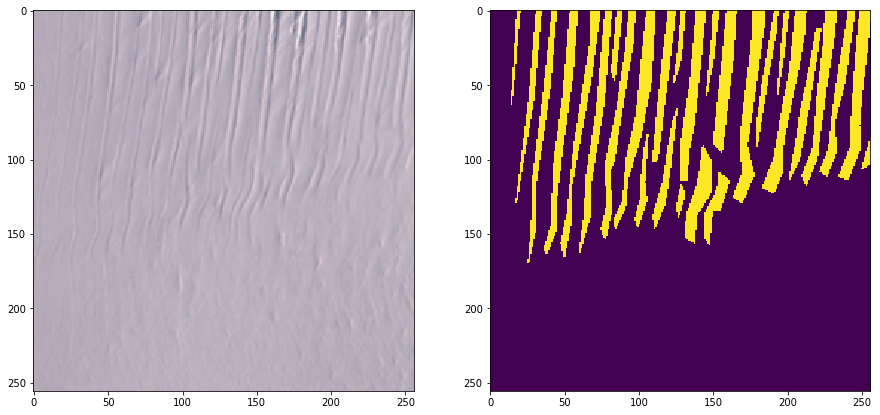

In [7]:
id = 64
fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(15,15))
axarr[0, 0].imshow(X_data[id])
axarr[0, 1].imshow(Y_data[id][:,:,0])
plt.show()

# Save to [quilt](https://quiltdata.com/)

This will make it a bit easier for anyone to reproduce the output data from this notebook without going through all the steps above :P

In [8]:
import quilt

In [9]:
if os.path.exists('model/build.yml'):
    os.remove('model/build.yml')
quilt.generate(directory="model")

Generated build-file model/build.yml.


In [10]:
quilt.login()

Launching a web browser...
If that didn't work, please visit the following URL: https://pkg.quiltdata.com/login

Enter the code from the webpage: AEdUZcp1BmklNiR4rvj85lNOOt6mh8


In [11]:
quilt.build(package='weiji14/nz_space_challenge', path='model/build.yml')

Inferring 'transform: id' for README.md
Registering model/README.md...
Inferring 'transform: id' for intertrain/crevasse_map.tif
Registering model/intertrain/crevasse_map.tif...
Inferring 'transform: id' for intertrain/earthobservation_map.tif
Registering model/intertrain/earthobservation_map.tif...
Inferring 'transform: id' for train/X_data.npy
Registering model/train/X_data.npy...
Inferring 'transform: id' for train/Y_data.npy
Registering model/train/Y_data.npy...
Built weiji14/nz_space_challenge successfully.


In [12]:
quilt.push(package='weiji14/nz_space_challenge', is_public=True)

Fetching upload URLs from the registry...


  0%|          | 0.00/352M [00:00<?, ?B/s]

Uploading 5 fragments (352329462 bytes before compression)...


100%|██████████| 352M/352M [00:27<00:00, 12.9MB/s]    


Uploading package metadata...
Updating the 'latest' tag...
Push complete. weiji14/nz_space_challenge is live:
https://quiltdata.com/package/weiji14/nz_space_challenge
